In [1]:
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import mne

import numpy as np

In [2]:
# Loading data from .mat file
folder = '/home/pedrosergiot/Documents/dados_coletas/Com_Remocao_Artefato/5s'

config = loadmat(folder + '/' + 'AnaClara3_05_2k_Pedro2' + '/config.mat')
exame = loadmat(folder + '/' + 'AnaClara3_05_2k_Pedro2' + '/exame_1.mat')

fs = float(config['Fs'])
eletrodos = ['F7','T3','T5','Fp1','F3','C3','P3','O1','F8','T4','T6','Fp2','F4','C4','P4','O2','Fz','Cz','Pz']
sinal = exame['dadosREJEICAO'][10*64:6144,0:19]

sinal.shape

(5504, 19)

Creating RawArray with float64 data, n_channels=19, n_times=5504
    Range : 0 ... 5503 =      0.000 ...     9.149 secs
Ready.


Traceback (most recent call last):
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/viz/utils.py", line 756, in _resize_event
    _update_borders(params, new_width, new_height)
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/viz/utils.py", line 575, in _update_borders
    params['zen_w_delta'] *= old_width / new_width
KeyError: 'zen_w_delta'


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 93 unique labels.


/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-e3691273782b>:21: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_f

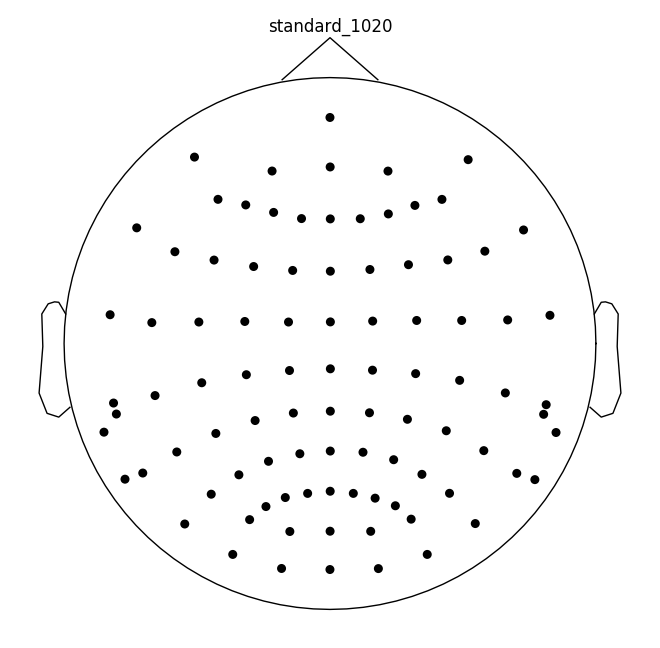

In [3]:
# Construction of Raw object for MNE

ch_types = 'eeg'
ch_names = eletrodos

info = mne.create_info(ch_names=ch_names,ch_types=ch_types,sfreq=fs) # info for raw object

scaler = StandardScaler()
sinal_std = scaler.fit_transform(sinal)

raw = mne.io.RawArray(sinal.T,info)

%matplotlib tk

raw.plot(scalings=20,show_options = True)

plt.savefig('/home/pedrosergiot/Documents/figura')

montage = mne.channels.read_montage('standard_1020') # Layout of electrodes
ch_index = mne.pick_channels(montage.ch_names,eletrodos)
mne.viz.plot_montage(montage, show_names=False)


In [4]:
exame.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 01 09:44:16 2017'), ('__version__', '1.0'), ('__globals__', []), ('ladoAT', array([[1]], dtype=uint8)), ('contaJanelaTOTAL', array([[7]], dtype=uint8)), ('dadosSinal', array([[ 1.16708347, -2.26322165, -2.21170688, ..., -0.34738154,
         0.28990005,  0.        ],
       [ 2.97081815, -0.85188997,  1.03808972, ...,  0.71611049,
         1.53145589,  0.        ],
       [ 4.5876407 ,  0.38537941,  3.84380542, ...,  1.63863913,
         2.64795955,  0.        ],
       ...,
       [ 4.31904992,  3.63329901,  2.16285412, ...,  1.7469711 ,
         3.52723481,  0.        ],
       [ 3.75614135,  3.36424208,  0.79009296, ...,  2.06508189,
         3.55547483,  0.        ],
       [ 3.38575976,  3.19336866, -0.82699234, ...,  2.58936943,
         3.68710564,  0.        ]])), ('in_at_esq', array([[ 0.        ,  0.        , -0.16333382, -0.23105628, -0.07746598,
         0.00350045]])), ('in_at_dir', ar

In [13]:
canal.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Jul 06 16:27:25 2011'), ('__version__', '1.0'), ('__globals__', []), ('canal', array(['F7\x00 ', 'T3\x00 ', 'T5\x00 ', 'Fp1', 'F3\x00 ', 'C3\x00 ',
       'P3\x00 ', 'O1\x00 ', 'F8\x00 ', 'T4\x00 ', 'T6\x00 ', 'Fp2',
       'F4\x00 ', 'C4\x00 ', 'P4\x00 ', 'O2\x00 ', 'Fz\x00 ', 'Cz\x00 ',
       'Pz\x00 ', 'Oz\x00 ', 'A1\x00 ', 'A2\x00 ', 'TRIG'], dtype='<U4'))])

In [9]:
# ICA Analysis

# Whitening by means of PCA
#pca = PCA(whiten=True)
#sinal_std = pca.fit_transform(sinal_std)

raw_std = mne.io.RawArray(sinal_std.T,info)
raw_std.set_montage(montage)
filt_raw_std = raw_std.copy()  # use of copy to create a copy of object (equal sign only creates a reference to the object already existing)

# Filtering for slow drifits (high-pass with cutoff frequency of 1 Hz)
#filt_raw_std.load_data().filter(l_freq=1., h_freq=None)

# Initialize the ICA object (fastICA is the default algorithm)
ica = mne.preprocessing.ICA(method='infomax')
ica.fit(filt_raw_std)

ica.plot_sources(raw_std)
ica.plot_components()
print(raw_std.shape)
#ica.plot_properties(raw_std)


Creating RawArray with float64 data, n_channels=19, n_times=5504
    Range : 0 ... 5503 =      0.000 ...     9.149 secs
Ready.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 19
 


<ipython-input-9-0211bfb6b8b0>:8: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhemus_isotrak``, or ``read_dig_captrack`` ``read_dig_hpts``, ``read_dig_captrack`` or ``read_custom_montage`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays.
  raw_std.set_montage(montage)


Fitting ICA took 0.8s.


Traceback (most recent call last):
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/viz/utils.py", line 756, in _resize_event
    _update_borders(params, new_width, new_height)
  File "/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/mne/viz/utils.py", line 575, in _update_borders
    params['zen_w_delta'] *= old_width / new_width
KeyError: 'zen_w_delta'


AttributeError: 'RawArray' object has no attribute 'shape'